In [8]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(DBI)
library(dbplyr)
options(repr.matrix.max.rows = 6)

In [9]:
atp_data_frame <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(atp_data_frame)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


In [10]:
colnames(atp_data_frame)

[1] "X1"                 "tourney_id"         "tourney_name"      
 [4] "surface"            "draw_size"          "tourney_level"     
 [7] "tourney_date"       "match_num"          "winner_id"         
[10] "winner_seed"        "winner_entry"       "winner_name"       
[13] "winner_hand"        "winner_ht"          "winner_ioc"        
[16] "winner_age"         "loser_id"           "loser_seed"        
[19] "loser_entry"        "loser_name"         "loser_hand"        
[22] "loser_ht"           "loser_ioc"          "loser_age"         
[25] "score"              "best_of"            "round"             
[28] "minutes"            "w_ace"              "w_df"              
[31] "w_svpt"             "w_1stIn"            "w_1stWon"          
[34] "w_2ndWon"           "w_SvGms"            "w_bpSaved"         
[37] "w_bpFaced"          "l_ace"              "l_df"              
[40] "l_svpt"             "l_1stIn"            "l_1stWon"          
[43] "l_2ndWon"           "l_SvGms"            "l_bpSaved"         
[46] "l_bpFaced"          "winner_rank"        "winner_rank_points"
[49] "loser_rank"         "loser_rank_points"

In [11]:
player_wins <- atp_data_frame %>%
    group_by(player_id = winner_id) %>%
    summarize(w_height = mean(winner_ht, na.rm =TRUE),
              w_breakpoint_saved_pct = mean(w_bpSaved/w_bpFaced, na.rm =TRUE),
              w_second_serve_win_pct = mean(w_2ndWon / w_svpt,na.rm =TRUE),
              w_df_pct = mean(w_df / w_svpt,na.rm =TRUE),
              w_first_serve_pct = mean(w_1stWon / w_1stIn,na.rm =TRUE),
              n_wins = n(),
              mean_age_w  = mean(winner_age),
              mean_rank_points_w = mean(winner_rank_points)    
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))


player_lose <- atp_data_frame %>%
    group_by(player_id = loser_id) %>%
    summarize(l_height = mean(loser_ht, na.rm =TRUE),
              l_breakpoint_saved_pct = mean(l_bpSaved/l_bpFaced, na.rm =TRUE),
              l_second_serve_win_pct = mean(l_2ndWon / l_svpt,na.rm =TRUE),
              l_df_pct = mean(l_df / l_svpt, na.rm =TRUE),
              l_first_serve_pct = mean(l_1stWon / l_1stIn,na.rm =TRUE),
              n_lose = n(),
              mean_age_l  = mean(loser_age),
              mean_rank_points_l = mean(loser_rank_points)    
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

player_join <- left_join(player_wins, player_lose, by = NULL, copy = TRUE)

player_career <- player_join %>%
    mutate(height = (w_height + l_height)/2,
          breakpoint_saved_pct = (w_breakpoint_saved_pct+l_breakpoint_saved_pct)/2,
          second_serve_win_pct = (w_second_serve_win_pct+l_second_serve_win_pct)/2,
          df_pct = (w_df_pct+l_df_pct)/2,
          first_serve_pct = (w_first_serve_pct+l_first_serve_pct)/2,
          win_rate = (n_wins/(n_lose+n_wins)*100),
          age = (mean_age_w + mean_age_l) /2,
          mean_rank_points = (mean_rank_points_w + mean_rank_points_l)/2) %>%
    select(player_id,height,breakpoint_saved_pct,second_serve_win_pct,df_pct,first_serve_pct,win_rate,age,mean_rank_points) %>%
    drop_na()

player_career

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "player_id"



player_id,height,breakpoint_saved_pct,second_serve_win_pct,df_pct,first_serve_pct,win_rate,age,mean_rank_points
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100644,198,0.5592240,0.1700660,0.05146736,0.7351579,69.34673,21.15730,4281.6435
103333,208,0.7024075,0.1934502,0.05467902,0.8336761,41.02564,39.12084,962.8682
103819,185,0.6093525,0.2114465,0.02279807,0.7770562,84.17722,37.09069,6720.2910
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
106296,183,0.5769397,0.1768606,0.04200586,0.6743243,33.33333,25.12377,458.375
106298,185,0.6420310,0.2225114,0.04366584,0.7383816,58.08824,24.20236,1914.473
106401,193,0.6480872,0.1862049,0.04705221,0.7819567,62.71186,23.02092,1722.535


In [12]:

set.seed(1)
player_split <- initial_split(player_career, prop = 0.75, strata = win_rate)
player_train <- training(player_split)
player_test <- testing(player_split)

print("Creating recipe")
tennis_recipe <- recipe(win_rate ~ ., data = player_train) %>%
  step_rm(player_id) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

print("Creating spec")
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

print("Creating folds")
tennis_vfold <- vfold_cv(player_train, v = 5, strata = win_rate)

print("Creating workflow")
tennis_wkflw <- workflow() %>%
  add_recipe(tennis_recipe) %>%
  add_model(tennis_spec)

gridvals <- tibble(neighbors = seq(1,50))

print("Tuning grid")
tennis_results <- tennis_wkflw %>%
    tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
    collect_metrics()

tennis_min <- tennis_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1)

tennis_min

[1] "Creating recipe"
[1] "Creating spec"
[1] "Creating folds"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "Creating workflow"
[1] "Tuning grid"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,10.26389,5,0.7897034,Model02


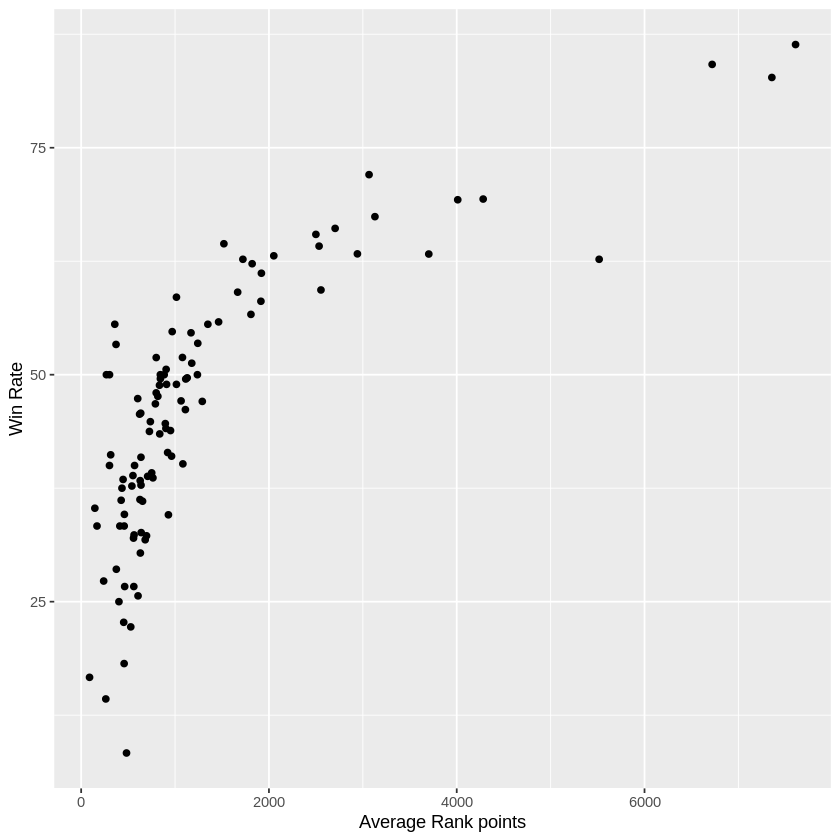

In [13]:
ggplot(player_career, aes(x=mean_rank_points,y=win_rate)) + 
    geom_point() +
    xlab("Average Rank points") +
    ylab("Win Rate")